In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.formula.api import ols
import numpy as np
from functools import reduce

def plot_2_lines(x1, x2, title):
    ax1 = x1.plot(figsize = (17, 7), color = '#ff7f0e', title = title)

    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    x2.plot(ax=ax2, color = '#1f77b4')

#### Orderbook data

In [2]:
d = pd.read_pickle("data/imbalance.pkl")
d["day"] = d.ts.dt.floor('d')
d.head(3)

,ts,askp,askv,bidp,bidv,saskp,saskv,sbidp,sbidv,bidpincrease,bidpdecrease,askpincrease,askpdecrease,mid,smid,change,imb,day
0,2018-04-17 10:56:24,8099.0,2.469,8094.0,1.19,8099.0,0.218,8094.0,1.00,True,True,True,True,8096.50,8096.50,0.000000,2.061,2018-04-17
1,2018-04-17 10:56:29,8098.9,0.209,8095.0,0.60,8099.0,2.469,8094.0,1.19,False,True,True,False,8096.95,8096.50,-0.000056,-0.391,2018-04-17
2,2018-04-17 10:56:35,8099.5,2.469,8095.0,0.60,8098.9,0.209,8095.0,0.60,True,True,False,True,8097.25,8096.95,-0.000037,-0.209,2018-04-17


#### First value in day of askp and bidp

In [3]:
firstvalue = d.groupby(['day'], as_index= False).nth([0])[['day', 'askp', 'bidp']].reset_index(drop = False)
firstvalue = firstvalue.add_prefix('first_')
firstvalue = firstvalue.rename({"first_day":"day"}, axis = 1)
firstvalue = firstvalue.drop(['first_index'], axis = 1)
firstvalue.head(2)

,day,first_askp,first_bidp
0,2018-04-17,8099.0,8094.0
1,2018-04-18,7893.1,7893.0


#### Last value in day of askp and bidp

In [4]:
lastvalue = d.groupby(['day'], as_index= False).nth([-1])[['day', 'askp', 'bidp']].reset_index(drop = False)
lastvalue = lastvalue.add_prefix('last_')
lastvalue = lastvalue.rename({"last_day":"day"}, axis = 1)
lastvalue = lastvalue.drop(['last_index'], axis = 1)
lastvalue.head(2)

,day,last_askp,last_bidp
0,2018-04-17,7893.1,7893.0
1,2018-04-18,8170.6,8170.4


#### Minimum value in day of askp, bidp, mid ::::: (min askv and bidv is always 0.001 so no purpose of them)

In [5]:
minvalue = pd.DataFrame(d.groupby(['day'])['askp', 'bidp', 'imb'].agg('min')).reset_index(drop = False)
minvalue = minvalue.add_prefix('min_')
minvalue = minvalue.rename({"min_day":"day"}, axis = 1)
minvalue.head(2)

,day,min_askp,min_bidp,min_imb
0,2018-04-17,7830.1,7817.1,-84.283
1,2018-04-18,7881.1,7875.6,-78.035


#### Maximum value in day of askp, bidp, bidv, askv, imb

In [6]:
maxvalue = pd.DataFrame(d.groupby(['day'])['askp', 'bidp', 'bidv', 'askv', 'imb'].agg('max')).reset_index(drop = False)
maxvalue = maxvalue.add_prefix('max_')
maxvalue = maxvalue.rename({"max_day":"day"}, axis = 1)
maxvalue.head(2)

,day,max_askp,max_bidp,max_bidv,max_askv,max_imb
0,2018-04-17,8160.1,8160.0,84.834,99.914,98.872
1,2018-04-18,8296.8,8250.0,85.969,85.814,85.921


#### Sum of whole day's imbalance

In [7]:
sumi = pd.DataFrame(d.groupby(['day'])['imb'].agg('sum')).reset_index(drop = False)
sumi = sumi.add_prefix('sum_')
sumi = sumi.rename({"sum_day":"day"}, axis = 1)
sumi.head(2)

,day,sum_imb
0,2018-04-17,544.339
1,2018-04-18,143.030


#### Merging all datasets to one

In [8]:
dfs_to_join = [firstvalue, lastvalue, minvalue, maxvalue, sumi]
df = reduce(lambda left,right: pd.merge(left,right,on='day'), dfs_to_join)
df.head(3)

,day,first_askp,first_bidp,last_askp,last_bidp,min_askp,min_bidp,min_imb,max_askp,max_bidp,max_bidv,max_askv,max_imb,sum_imb
0,2018-04-17,8099.0,8094.0,7893.1,7893.0,7830.1,7817.1,-84.283,8160.1,8160.0,84.834,99.914,98.872,544.339
1,2018-04-18,7893.1,7893.0,8170.6,8170.4,7881.1,7875.6,-78.035,8296.8,8250.0,85.969,85.814,85.921,143.030
2,2018-04-19,8174.4,8170.3,8275.9,8267.5,8100.5,8099.6,-60.543,8299.9,8298.9,63.221,60.754,63.420,-428.747


#### Calculating mid price at the start and end of the day

In [9]:
df["first_mid"] = ( df.first_askp + df.first_bidp ) / 2
df["last_mid"] = ( df.last_askp + df.last_bidp ) / 2
df.head(3)

,day,first_askp,first_bidp,last_askp,last_bidp,min_askp,min_bidp,min_imb,max_askp,max_bidp,max_bidv,max_askv,max_imb,sum_imb,first_mid,last_mid
0,2018-04-17,8099.0,8094.0,7893.1,7893.0,7830.1,7817.1,-84.283,8160.1,8160.0,84.834,99.914,98.872,544.339,8096.50,7893.05
1,2018-04-18,7893.1,7893.0,8170.6,8170.4,7881.1,7875.6,-78.035,8296.8,8250.0,85.969,85.814,85.921,143.030,7893.05,8170.50
2,2018-04-19,8174.4,8170.3,8275.9,8267.5,8100.5,8099.6,-60.543,8299.9,8298.9,63.221,60.754,63.420,-428.747,8172.35,8271.70


#### Feature engineering

In [10]:
df["askp_oc_diff"] = df.last_askp - df.first_askp
df["bidp_oc_diff"] = df.last_bidp - df.first_bidp
df["askp_hl_diff"] = df.max_askp - df.min_askp
df["bidp_hl_diff"] = df.max_bidp - df.min_bidp
df['bidv_askp_max_diff'] = df.max_bidv - df.max_askv
df = df.drop(['first_askp', 'last_askp', 'first_bidp', 'last_bidp', 'min_bidp',
              'max_bidp', 'min_askp', 'max_askp', 'max_bidv', 'max_askv'], axis = 1)
df.head(3)

,day,min_imb,max_imb,sum_imb,first_mid,last_mid,askp_oc_diff,bidp_oc_diff,askp_hl_diff,bidp_hl_diff,bidv_askp_max_diff
0,2018-04-17,-84.283,98.872,544.339,8096.50,7893.05,-205.9,-201.0,330.0,342.9,-15.080
1,2018-04-18,-78.035,85.921,143.030,7893.05,8170.50,277.5,277.4,415.7,374.4,0.155
2,2018-04-19,-60.543,63.420,-428.747,8172.35,8271.70,101.5,97.2,199.4,199.3,2.467


#### Calculating day's change and % change in mid price, shifting change to avoid look-ahead bias

In [11]:
df["pct_change"] = 100*(df.last_mid - df.first_mid) / df.first_mid
df = df.drop( ['first_mid', 'last_mid'] , axis = 1)
df["s_pct_change"] = df["pct_change"].shift(-1)
df = df.drop(['pct_change'], axis = 1)
df = df.iloc[1:-1, :].reset_index(drop = True)
df.head(3)

,day,min_imb,max_imb,sum_imb,askp_oc_diff,bidp_oc_diff,askp_hl_diff,bidp_hl_diff,bidv_askp_max_diff,s_pct_change
0,2018-04-18,-78.035,85.921,143.030,277.5,277.4,415.7,374.4,0.155,1.215685
1,2018-04-19,-60.543,63.420,-428.747,101.5,97.2,199.4,199.3,2.467,7.318326
2,2018-04-20,-101.000,94.933,123.329,604.1,606.6,716.2,708.3,40.868,0.713799


### Linear plots

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("ticks")
y = df["s_pct_change"]

#### min imbalance

<AxesSubplot:xlabel='min_imb', ylabel='s_pct_change'>

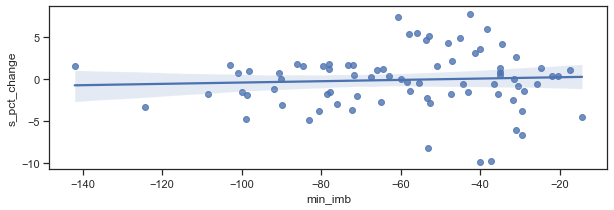

In [13]:
sns.regplot(df.min_imb, y, robust = True, label = 'te')

#### max imbalance

<AxesSubplot:xlabel='max_imb', ylabel='s_pct_change'>

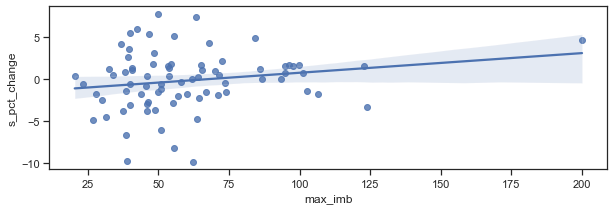

In [14]:
sns.regplot(df.max_imb, y, robust = True, label = 'te')

#### sum imbalance

<AxesSubplot:xlabel='sum_imb', ylabel='s_pct_change'>

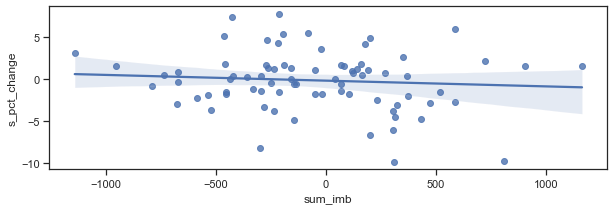

In [15]:
sns.regplot(df.sum_imb, y, robust = True, label = 'te')

#### close askp - open askp

<AxesSubplot:xlabel='askp_oc_diff', ylabel='s_pct_change'>

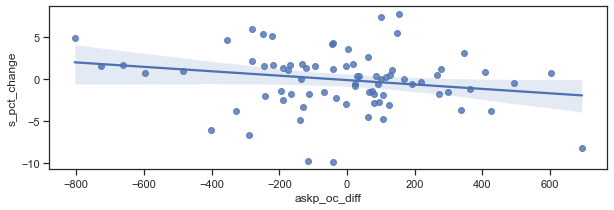

In [16]:
sns.regplot(df.askp_oc_diff, y, robust = True, label = 'te')

#### close bidp - open bidp

<AxesSubplot:xlabel='bidp_oc_diff', ylabel='s_pct_change'>

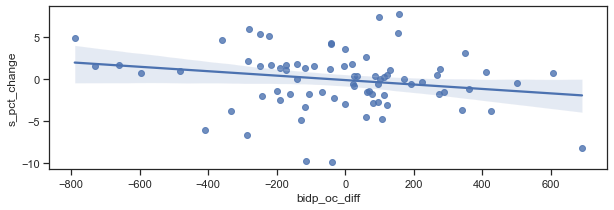

In [17]:
sns.regplot(df.bidp_oc_diff, y, robust = True, label = 'te')

#### high askp - low askp

<AxesSubplot:xlabel='askp_hl_diff', ylabel='s_pct_change'>

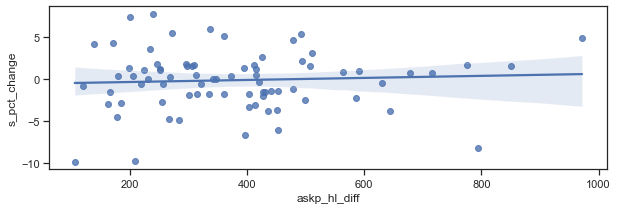

In [18]:
sns.regplot(df.askp_hl_diff, y, robust = True, label = 'te')

#### high bidp - low bidp

<AxesSubplot:xlabel='bidp_hl_diff', ylabel='s_pct_change'>

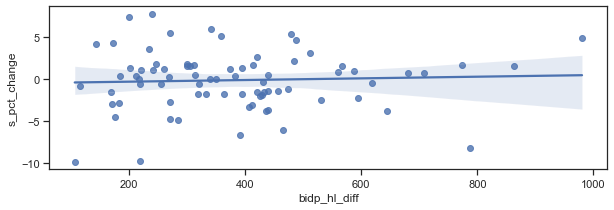

In [19]:
sns.regplot(df.bidp_hl_diff, y, robust = True, label = 'te')

#### max bidp - max askp

<AxesSubplot:xlabel='bidv_askp_max_diff', ylabel='s_pct_change'>

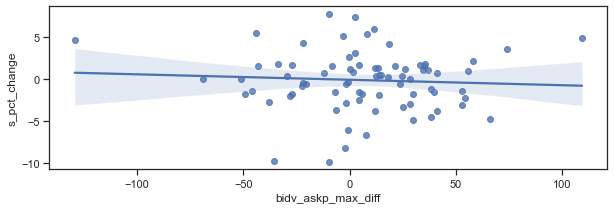

In [20]:
sns.regplot(df.bidv_askp_max_diff, y, robust = True, label = 'te')

### Linear regression

In [40]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.api import OLS

In [49]:
regdf = df.iloc[:, 1:]
regdf.head(3)

,min_imb,max_imb,sum_imb,askp_oc_diff,bidp_oc_diff,askp_hl_diff,bidp_hl_diff,bidv_askp_max_diff,s_pct_change
0,-78.035,85.921,143.030,277.5,277.4,415.7,374.4,0.155,1.215685
1,-60.543,63.420,-428.747,101.5,97.2,199.4,199.3,2.467,7.318326
2,-101.000,94.933,123.329,604.1,606.6,716.2,708.3,40.868,0.713799


In [50]:
split = int(regdf.shape[0] * 0.75)

x = regdf.iloc[:, :-1]
y = regdf.iloc[:, -1]

trainx, trainy, testx, testy  = x.iloc[:split, :], y.iloc[:split], x.iloc[split:, :], y.iloc[split:]
trainx.shape, trainy.shape, testx.shape, testy.shape

((58, 8), (58,), (20, 8), (20,))

In [51]:
model = OLS(trainy,trainx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           s_pct_change   R-squared (uncentered):                   0.170
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              1.281
Date:                Sat, 12 Mar 2022   Prob (F-statistic):                       0.275
Time:                        01:05:43   Log-Likelihood:                         -149.30
No. Observations:                  58   AIC:                                      314.6
Df Residuals:                      50   BIC:                                      331.1
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
min_imb                0.0235      0.020      1.149      0.256      -0.018       0.065
max_imb                0.0302      0.023      1.328      0.190      -0.015       0.076
sum_imb               -0.0021      0.001     -1.698      0.096      -0.005       0.000
askp_oc_diff           0.0310      0.098      0.315      0.754      -0.167       0.228
bidp_oc_diff          -0.0338      0.099     -0.343      0.733      -0.232       0.164
askp_hl_diff           0.0286      0.025      1.153      0.254      -0.021       0.078
bidp_hl_diff          -0.0309      0.025     -1.247      0.218      -0.081       0.019
bidv_askp_max_diff     0.0112      0.015      0.725      0.472      -0.020       0.042
==============================================================================
Omnibus:                        0.678   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.212
Skew:                           0.103   Prob(JB):                        0.899
Kurtosis:                       3.213   Cond. No.                         196.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

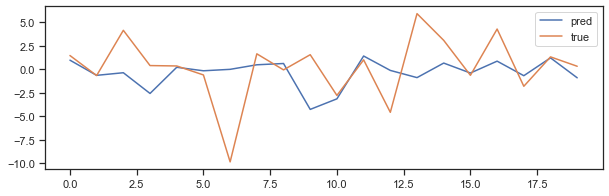

In [52]:
plt.plot(model.predict(testx).values, label = "pred")
plt.plot(testy.values, label = "true")
plt.legend()

### Standartized

In [53]:
regdf = ( regdf - regdf.mean() ) / regdf.std(ddof=1)

In [54]:
split = int(regdf.shape[0] * 0.75)

x = regdf.iloc[:, :-1]
y = regdf.iloc[:, -1]

trainx, trainy, testx, testy  = x.iloc[:split, :], y.iloc[:split], x.iloc[split:, :], y.iloc[split:]
trainx.shape, trainy.shape, testx.shape, testy.shape

((58, 8), (58,), (20, 8), (20,))

In [55]:
model = OLS(trainy,trainx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           s_pct_change   R-squared (uncentered):                   0.169
Model:                            OLS   Adj. R-squared (uncentered):              0.036
Method:                 Least Squares   F-statistic:                              1.267
Date:                Sat, 12 Mar 2022   Prob (F-statistic):                       0.282
Time:                        01:05:45   Log-Likelihood:                         -77.097
No. Observations:                  58   AIC:                                      170.2
Df Residuals:                      50   BIC:                                      186.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
min_imb                0.1196      0.184      0.649      0.519      -0.251       0.490
max_imb                0.2686      0.184      1.456      0.152      -0.102       0.639
sum_imb               -0.2781      0.155     -1.790      0.079      -0.590       0.034
askp_oc_diff           3.6119      7.976      0.453      0.653     -12.408      19.632
bidp_oc_diff          -3.8407      7.993     -0.481      0.633     -19.895      12.213
askp_hl_diff           1.4656      1.249      1.173      0.246      -1.043       3.975
bidp_hl_diff          -1.5360      1.252     -1.226      0.226      -4.052       0.980
bidv_askp_max_diff     0.1115      0.159      0.702      0.486      -0.208       0.431
==============================================================================
Omnibus:                        1.642   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.440   Jarque-Bera (JB):                0.927
Skew:                           0.251   Prob(JB):                        0.629
Kurtosis:                       3.361   Cond. No.                         145.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

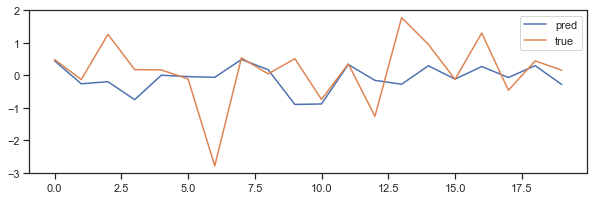

In [56]:
plt.plot(model.predict(testx).values, label = "pred")
plt.plot(testy.values, label = "true")
plt.legend()